In [1]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
    
import sys
sys.path.append(os.path.join(os.getcwd(), "iclr19-graph2graph", "props"))
sys.path.append(os.path.join(os.getcwd(), "otgnn"))

import importlib  
props = importlib.import_module("iclr19-graph2graph.props")

import numpy as np
import torch
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

from otgnn.utils import load_model
from otgnn.models import GCN, compute_ot
from otgnn.datasets import PropDataset
from otgnn.graph import MolGraph

from multiprocessing import Pool

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('dark_background')

import seaborn as sns
sns.set(font_scale=1.3, style = "whitegrid")
import pandas as pd

In [2]:
# load dataset
# dataset = PropDataset("data/sol/", data_type = "train")
dataset_name = "ZINC"
dataset = PropDataset("iclr19-graph2graph/data/qed", data_type = "wengong")
# path = "/home/octav/gitrepos/tum-thesis/images/"
path = "/home/octav/Dropbox/Apps/Overleaf/TUM Thesis/figures/"

iclr19-graph2graph/data/qed   wengong ; split= 0  num total=  88306  num pos= 0


In [3]:
# get molecular graphs for all molecules
# this takes a while
with Pool(20) as p:
    mol_graphs = p.map(MolGraph, dataset)

In [4]:
mol_graphs_lens = [(len(dp.mols[0].atoms), len(dp.mols[1].atoms)) for dp in mol_graphs]
mol_graphs_same = [x for i, x in enumerate(mol_graphs) if mol_graphs_lens[i][0] == mol_graphs_lens[i][1]]
len(mol_graphs_same), len(mol_graphs)

(5975, 88306)

# Get diagnostic stats about number of molecules

In [5]:
len_x = [x for (x, _) in mol_graphs_lens]
len_y = [y for (_, y) in mol_graphs_lens]

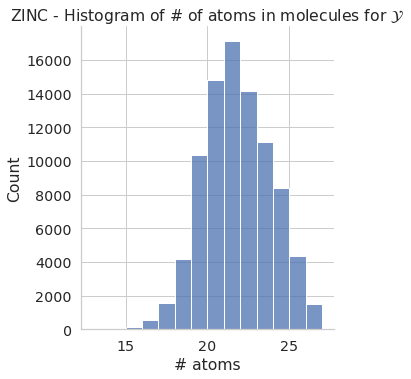

In [6]:
# plt.hist(len_x, bins = 20)
g = sns.displot(len_y,binwidth=1)
g.set(title = dataset_name + " - Histogram of # of atoms in molecules for $\mathcal{Y}$",
     xlabel = "# atoms")
plt.savefig(path + "{}_num_hist.png".format(dataset_name))

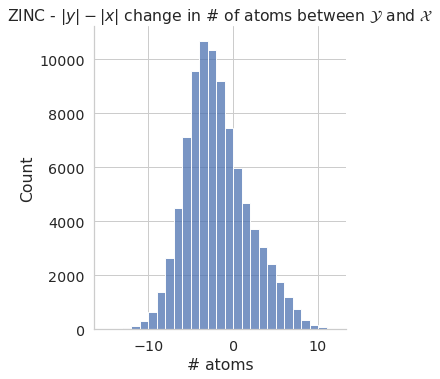

In [7]:
# plt.hist([y-x for (x, y) in mol_graphs_lens])
g = sns.displot([y-x for (x, y) in mol_graphs_lens], binwidth = 1)
g.set(title=dataset_name + " - $|y|-|x|$ change in # of atoms between $\mathcal{Y}$ and $\mathcal{X}$",
     xlabel = "# atoms")

plt.savefig(path +  "{}_delta_hist.png".format(dataset_name))

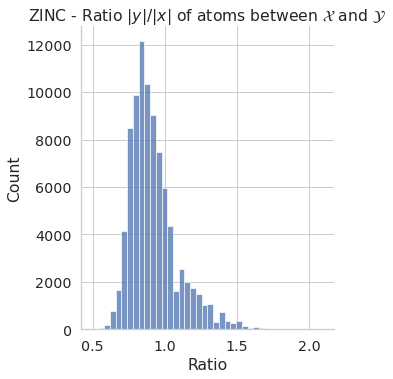

In [8]:
# plt.hist([y/x for (x, y) in mol_graphs_lens], bins = 40)
g = sns.displot([y/x for (x, y) in mol_graphs_lens], bins = 40)
g.set(title=dataset_name + " - Ratio $|y|/|x|$ of atoms between $\mathcal{X}$ and $\mathcal{Y}$",
     xlabel = "Ratio")
plt.savefig(path + "{}_ratio_hist.png".format(dataset_name))

# More stats

In [9]:
len(mol_graphs)

88306

In [10]:
x = mol_graphs[0].mols[1]

In [11]:
x.bonds[0].bond_type

rdkit.Chem.rdchem.BondType(1)

In [12]:
# total number of atoms
print (len(mol_graphs))

natoms = sum([len(x.mols[1].atoms) for x in mol_graphs])
avgatoms = natoms/len(mol_graphs)
print (natoms, avgatoms)


nbonds = sum([len(x.mols[1].bonds)/2 for x in mol_graphs])
degbonds = sum([sum([int(y.bond_type) for y in x.mols[1].bonds])/2 for x in mol_graphs])
avgbonds = nbonds/len(mol_graphs)
print (nbonds, avgbonds)
print (degbonds/natoms)

88306
1882791 21.321212601635224
2018103.0 22.853520712069393
1.3530200643618968


In [13]:
import rdkit
rdkit.Chem.rdchem.BondType.values

{0: rdkit.Chem.rdchem.BondType.UNSPECIFIED,
 1: rdkit.Chem.rdchem.BondType.SINGLE,
 2: rdkit.Chem.rdchem.BondType.DOUBLE,
 3: rdkit.Chem.rdchem.BondType.TRIPLE,
 4: rdkit.Chem.rdchem.BondType.QUADRUPLE,
 5: rdkit.Chem.rdchem.BondType.QUINTUPLE,
 6: rdkit.Chem.rdchem.BondType.HEXTUPLE,
 7: rdkit.Chem.rdchem.BondType.ONEANDAHALF,
 8: rdkit.Chem.rdchem.BondType.TWOANDAHALF,
 9: rdkit.Chem.rdchem.BondType.THREEANDAHALF,
 10: rdkit.Chem.rdchem.BondType.FOURANDAHALF,
 11: rdkit.Chem.rdchem.BondType.FIVEANDAHALF,
 12: rdkit.Chem.rdchem.BondType.AROMATIC,
 13: rdkit.Chem.rdchem.BondType.IONIC,
 14: rdkit.Chem.rdchem.BondType.HYDROGEN,
 15: rdkit.Chem.rdchem.BondType.THREECENTER,
 16: rdkit.Chem.rdchem.BondType.DATIVEONE,
 17: rdkit.Chem.rdchem.BondType.DATIVE,
 18: rdkit.Chem.rdchem.BondType.DATIVEL,
 19: rdkit.Chem.rdchem.BondType.DATIVER,
 20: rdkit.Chem.rdchem.BondType.OTHER,
 21: rdkit.Chem.rdchem.BondType.ZERO}

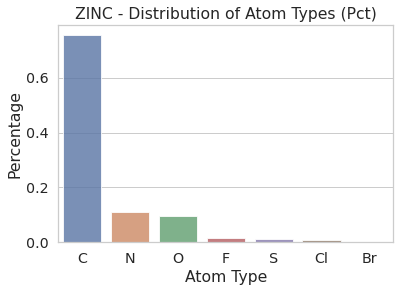

In [14]:
symbols = [x.symbol for y in mol_graphs for x in y.mols[1].atoms]
symb_counts = pd.Series(symbols).value_counts().reset_index()
symb_counts[0] = symb_counts[0]/symb_counts[0].sum()

g = sns.barplot(y = 0, x = "index", data = symb_counts, ci="sd", alpha = 0.8)
# g.despine(left=True)
g.set_xlabel("Atom Type")
g.set_ylabel("Percentage")
g.set_title(dataset_name + " - Distribution of Atom Types (Pct)")

plt.savefig(path + "{}_atom_types.png".format(dataset_name))

In [15]:
g.hlines

<bound method Axes.hlines of <AxesSubplot:title={'center':'ZINC - Distribution of Atom Types (Pct)'}, xlabel='Atom Type', ylabel='Percentage'>>

In [16]:
def naming_fc(idx):
    if idx == 1:
        return "Single"
    if idx == 2:
        return "Double"
    if idx == 3:
        return "Triple"
    

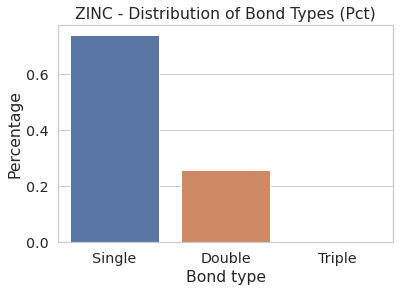

In [17]:
bonds = [x.bond_type for y in mol_graphs for x in y.mols[1].bonds]
bond_counts = pd.Series(bonds).value_counts().reset_index()
bond_counts[0] = bond_counts[0]/bond_counts[0].sum()
bond_counts["names"] = bond_counts["index"].map(naming_fc)

g = sns.barplot(y = 0, x = "names", data = bond_counts)
g.set_title(dataset_name + " - Distribution of Bond Types (Pct)")
g.set_xlabel("Bond type")
g.set_ylabel("Percentage")

plt.savefig(path + "{}_bond_types.png".format(dataset_name))

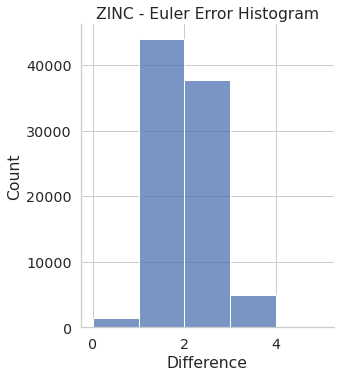

In [18]:
# euler error
# eulerr = [(sum([int(y.bond_type) for y in x.mols[1].bonds])/2 - len(x.mols[1].atoms)) for x in mol_graphs]
eulerr = [(len(x.mols[1].bonds)/2 - len(x.mols[1].atoms)) for x in mol_graphs]

g = sns.displot(eulerr, binwidth = 1)
g.set(title=dataset_name + " - Euler Error Histogram", xlabel = "Difference")

plt.savefig(path + "{}_euler_error.png".format(dataset_name))

# Complex stats

In [19]:
def fc(x):
    return props.similarity(*x)
with Pool(24) as p:
    simils = p.map(fc, dataset)

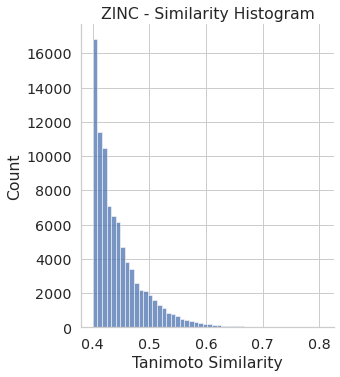

In [20]:
g = sns.displot(simils, bins = 50)
g.set(title=dataset_name + " - Similarity Histogram", xlabel = "Tanimoto Similarity")
plt.savefig(path + "{}_similarity.png".format(dataset_name))

In [21]:
Y = mol_graphs[0]
outs = Y.get_graph_outputs()

In [22]:
eulerr2 = []
idx = 1
wts = torch.tensor([1., 2., 3., 1., 0.], dtype=torch.float)

itr = 0
for Y in mol_graphs:
    le = Y.scope[idx][1]
    pred_bonds = outs[idx]["BOND_TYPES"]
    eulerr2.append((pred_bonds * wts).sum().item()/2 - le)
    
    if itr == 1:
        break
    else:
        itr+=1

In [23]:
eulerr2

[8.0, 10.0]

In [49]:
eulerr

[2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 3.0,
 1.0,
 2.0,
 3.0,
 2.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 2.0,
 1.0,
 0.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 3.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 2.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 3.0,
 2.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 2.0,
 3.0,
 2.0,
 1.0,
 1.0,
 2.0,
 3.0,
 2.0,
 1.0,
 2.0,
 1.0,
 3.0,
 1.0,
 0.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0

In [165]:
Y = mol_graphs[1].mols[1]

In [166]:
len(Y.atoms)

19

In [167]:
mol_graphs[1].scope

[(0, 23), (23, 19)]

In [168]:
Y.bonds

In [179]:
sum([int(y.bond_type) for y in Y.bonds])/2

24.0

In [180]:
(pred_bonds * wts).sum().item()/2

29.0

In [189]:
(1-pred_bonds[:,:,4]).sum()

tensor(46.)

In [192]:
len(Y.bonds)

40

In [198]:
display(Y)

# Visualize

In [24]:
import rdkit.Chem as Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

In [25]:
ds_sample = dataset.data[0:5]

In [26]:
mol_list = [(Chem.MolFromSmiles(x), Chem.MolFromSmiles(y)) for (x,y) in ds_sample]

In [27]:
rdDepictor.Compute2DCoords(mol_list[0][0])

0

In [28]:
x = mol_list[0][0]

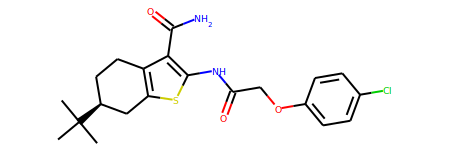

In [31]:
display(x)

In [32]:
len(mol_list)


5

In [34]:
len(simils)

88306

In [36]:
len(dataset)

88306

In [38]:
simils[:5]

[0.4166666666666667,
 0.4098360655737705,
 0.41379310344827586,
 0.4918032786885246,
 0.5]

In [56]:
np.where(np.array(simils) > 0.75)

(array([15661, 18962, 20182, 26699, 33610, 33666, 36167, 38805, 49700,
        54216, 57343, 62497, 67197, 69908, 75720, 84136]),)

In [60]:
dataset[15661]

('O=C([C@@H](c1ccccc1)C1CC1)N1CCC(OCc2ccc(F)cc2)CC1',
 'O=C([C@@H](O)c1ccccc1)N1CCC(OCc2ccc(F)cc2)CC1')

In [61]:
simils[15661]

0.7755102040816326

In [58]:
ds_sample = [dataset[1], dataset[15661]]
mol_list = [(Chem.MolFromSmiles(x), Chem.MolFromSmiles(y)) for (x,y) in ds_sample]

In [59]:
for i in range(2):
    for j in range(2):
        Chem.Draw.MolToFile(mol_list[i][j],path + 'mol_exp_{}_{}.png'.format(i, j))  